# LAB5 QIC

In [1]:
!pip install qiskit qiskit-aer qiskit-terra seaborn numpy matplotlib pip install qiskit-ibmq-provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 5.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 20.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 14.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 7.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 10.1

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table

In [4]:
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector,plot_bloch_multivector
from qiskit import IBMQ
import math
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np

## Quantum Key Distribution

### Protocol overview

The protocol makes use of the fact that measuring a qubit can change its state. As such, if Alice sends Bob a qubit and the eavesdropper (Eve) tries to measure it before Bob does, then there's a chance that Eve's measurement will change the state of the qubit and Bob will receive the qubit in a different state than the one Alice sent.

For example, if Alice prepares a qubit in the state $\ket{+} (0 in the X-basis) and Bob measures it in the same basis, then Bob will measure 0:

/opt/conda/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


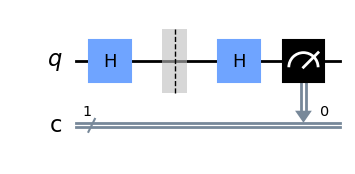

In [6]:
qc = QuantumCircuit(1,1)
# Alice prepares the qubit in state |+>
qc.h(0)
qc.barrier()
# Alice sends the qubit to Bob who will measure it in the X-basis
qc.h(0)
qc.measure(0,0)
qc.draw(output="mpl")

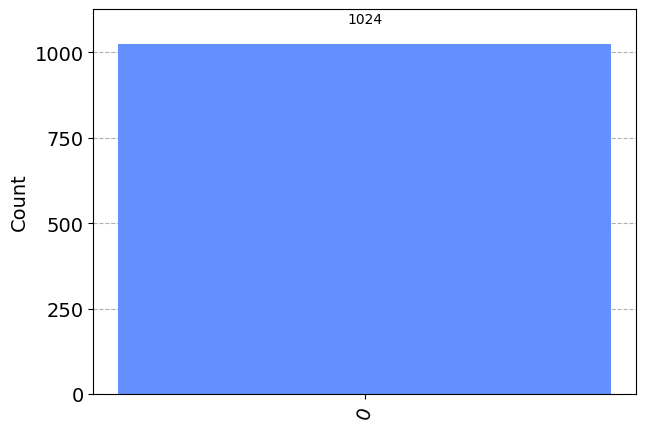

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

But if Eve tries to measure the qubit in the Z-basis before it reaches Bob, then she will change the qubit's state from $\ket{+}$ to $\ket{0}$ or $\ket{1}$, thus Bob will not measure 0.

/opt/conda/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


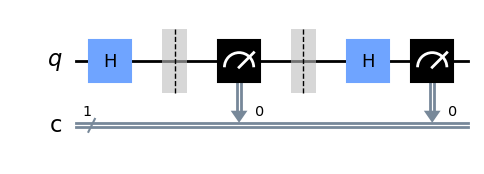

In [8]:
qc = QuantumCircuit(1,1)
# Alice prepares the qubit in state |+>
qc.h(0)
qc.barrier()
# Alice sends the qubit to Bob but Eve intercepts and tries to read it
qc.measure(0,0)
qc.barrier()
# Then Eve passes the qubit to Bob who will measure it in X-basis
qc.h(0)
qc.measure(0,0)
qc.draw(output="mpl")

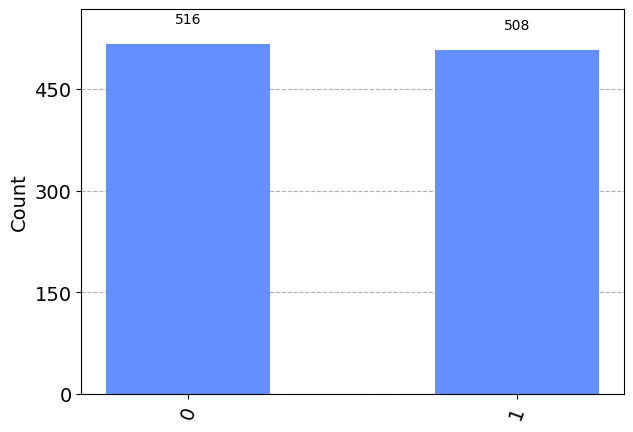

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

Thus, now Bob has a 50% chance of measuring 1, and if he does, both he and Alice will know there is something wrong with their channel.

The **QKD** protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. The Steps are:

#### Step 1

Alice chooses a string of random bits (e.g.: 1000101011010100) and a random choice of basis for each bit (ZZXZXXXZXZXXXXXX) and keeps these pieces of information private to herself.

#### Step 2

Alice encodes each bit into a string of qubits using the basis she chose; Thus, each qubit can be in one of the states: $\ket{0}$, $\ket{1}$, $\ket{+}$, and $\ket{-}$, chosen at random. Thus, in this example, the string of qubits will look like this:

$$
\ket{1}\ket{0}\ket{+}\ket{0}\ket{-}\ket{+}\ket{-}\ket{0}\ket{-}\ket{1}\ket{+}\ket{-}\ket{+}\ket{-}\ket{+}\ket{+}.
$$

This is the message she sends to Bob.

#### Step 3

Bob measures each qubit using a random choice of basis (e.g.: XZZZXZXZXZXZZZXZ) and keeps the results private.

#### Step 4

Bob and Alice now publicly share wich basis they used for each qubit. If bob measured a qubit in the same basis Alice prepared it in, they use it to form part of their shared secret key, otherwise they'll discard the information for that bit.

#### Step 5

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.

### Example without interception

In [20]:
np.random.seed(seed = 0)

In [21]:
# n is the length of Alice's initial message.
n = 128

In [22]:
# Step 1 -> generate a random set of bits
alice_bits = np.random.randint(2, size = n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1
 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |

In [23]:
# Step 2 -> Alice encodes each bit into a string of qubits in the X or Z-basis, at random. 
# We generate a random string of bits, a 0 means prepare in Z-basis, while a 1 means prepare in X-basis
alice_bases = np.random.randint(2, size = n)
print(alice_bases)

[1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0
 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1
 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |

In [29]:
# we define a function to encode the message in the corresponding basis
def encode(bits, bases, n):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: #prepare in Z-basis
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        else: # prepare in X basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [30]:
# And encode Alice's message
message = encode(alice_bits, alice_bases,n)

bit = 0
basis=1


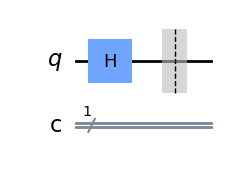

In [31]:
print('bit = %i' % alice_bits[0])
print('basis=%i' % alice_bases[0])
message[0].draw(output="mpl")

| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |

In [28]:
# Step 3 Bob measure each qubit in a random base, X or Z
bob_bases = np.random.randint(2, size = n)
print(bob_bases)

[1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0
 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0
 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |

In [36]:
#Define a function to measure message
def measure_message(message, bases, n):
    backend = Aer.get_backend("aer_simulator")
    results = []
    for q in range(n):
        if bases[q] == 0: #measuring in Z-basis
            message[q].measure(0,0)
        else: #measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        result = backend.run(message[q], shots = 1, memory = True).result()
        measured_bit = int(result.get_memory()[0])
        results.append(measured_bit)
    return results

In [37]:
bob_results = measure_message(message, bob_bases, n)

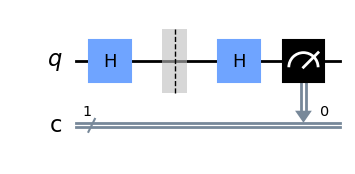

In [38]:
message[0].draw(output='mpl')

In [39]:
print(bob_results)

[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   |               | bob_result      |

Now, Alice reveals which qubits were encoded in which basis:
| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   | alice_bases   | alice_bases     |

And Bob reveals in which basis he measured each qubit:
| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   | alice_bases   | alice_bases     |
| bob_bases         | bob_bases     |                 |

In [42]:
#Step 4, Bob and Alice create their key
def create_key(a_bases, b_bases, bits, n):
    key = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            key.append(bits[q])
    return key

In [53]:
alice_key = create_key(alice_bases,bob_bases,alice_bits,n)
print(f"Alice's {len(alice_key)} key: {alice_key}")

Alice's 61 key: [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   | alice_bases   | alice_bases     |
| bob_bases         | bob_bases     |                 |
| alice_key         |               |                 |

In [54]:
bob_key = create_key(alice_bases, bob_bases, bob_results,n)
print(f"Bob's {len(bob_key)} key: {bob_key}" )

Bob's 61 key: [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   | alice_bases   | alice_bases     |
| bob_bases         | bob_bases     |                 |
| alice_key         |               | bob_key         |


In [55]:
#Step 5, they finally compare a random selection of bits in their keys to make sure the protocol has worked correctly
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits))
        sample.append(bits.pop(i))
    return sample

In [56]:
sample_size = 32
bit_selection = np.random.randint(n, size = sample_size)

In [57]:
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)
print(f"Bob's sample:\t{bob_sample}\nAlice's sample:\t{alice_sample}")

Bob's sample:	[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Alice's sample:	[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]


| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   | alice_bases   | alice_bases     |
| bob_bases         | bob_bases     |                 |
| alice_key         |               | bob_key         |
| bob_sample        | bob_sample    | bob_sample      |
| alice_sample      | alice_sample  | alice_sample    |

In [58]:
bob_sample == alice_sample

True

| Alice's knowledge | Eve's channel | Bob's knowledge |
|-------------------|---------------|-----------------|
| alice_bits        |               |                 |
| alice_bases       |               |                 |
| message           | message       | message         |
|                   |               | bob_bases       |
|                   | alice_bases   | alice_bases     |
| bob_bases         | bob_bases     |                 |
| alice_key         |               | bob_key         |
| bob_sample        | bob_sample    | bob_sample      |
| alice_sample      | alice_sample  | alice_sample    |
| shared_key        |               | shared_key      |

In [59]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
key length = 29


### Example with interception

In [72]:
np.random.seed(3)

In [73]:
# n is the length of Alice's initial message.
n = 128

In [74]:
# Step 1 -> generate a random set of bits
alice_bits = np.random.randint(2, size = n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1]


In [75]:
# Step 2 -> Alice encodes each bit into a string of qubits in the X or Z-basis, at random. 
# We generate a random string of bits, a 0 means prepare in Z-basis, while a 1 means prepare in X-basis
alice_bases = np.random.randint(2, size = n)
print(alice_bases)

[1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1
 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1
 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1
 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0]


In [84]:
# And encode Alice's message
message = encode(alice_bits, alice_bases,n)

bit = 0
basis=1


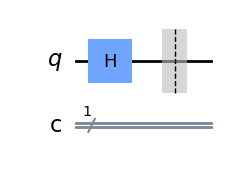

In [85]:
print('bit = %i' % alice_bits[0])
print('basis=%i' % alice_bases[0])
message[0].draw(output="mpl")

#### Interception

In [86]:
eve_bases = np.random.randint(2, size = n)
intercepted_message = measure_message(message, eve_bases,n)
print(f"Eve's intercepted message: {intercepted_message}")

Eve's intercepted message: [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]


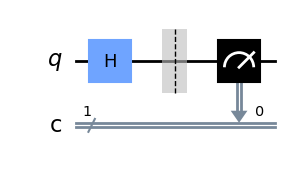

In [87]:
message[0].draw(output="mpl")

In [88]:
# Step 3 Bob measure each qubit in a random base, X or Z
bob_bases = np.random.randint(2, size = n)
print(bob_bases)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0
 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1
 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0
 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1]


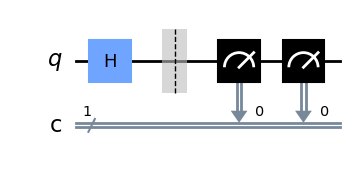

In [89]:
bob_results = measure_message(message, bob_bases, n)
message[0].draw(output="mpl")

In [90]:
print(bob_results)

[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]


In [91]:
alice_key = create_key(alice_bases,bob_bases,alice_bits,n)
print(f"Alice's {len(alice_key)} key: {alice_key}")

Alice's 71 key: [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


In [92]:
bob_key = create_key(alice_bases, bob_bases, bob_results,n)
print(f"Bob's {len(bob_key)} key: {bob_key}" )

Bob's 71 key: [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


In [96]:
sample_size = 5
bit_selection = np.random.randint(n, size = sample_size)

In [97]:
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)
print(f"Bob's sample:\t{bob_sample}\nAlice's sample:\t{alice_sample}")

Bob's sample:	[0, 0, 0, 1, 1]
Alice's sample:	[0, 0, 0, 1, 1]


In [98]:
bob_sample == alice_sample

True

### Discussions

For this type of interception, in which Eve measures all the qubits, there is a small chance that Bob and Alice's samples could match, and Alice sends her vulnerable message through Eve's channel. 

1. For Alice and Bob to use a qubit's result, they must both have chosen the same basis. If Eve chooses this basis too, then she will successfully intercept the message without introducing any error. There's a 50% chance of this happening, and the interception goes undetected.
2. If Eve chooses the wrong basis, ther's still a 50% chance Bob will measure the value Alice was trying to send, thus the interception goes undetected.


Thus, if Alice and Bob compare only 1 bit from their keys, the probability of a match is 0.75 (they will not notice Eve's intervention). But, if they measure 2 bits, there's a $075^2=0.5625$ chance of interception not being noticed. Therefore, the probability of Eve going undetected is $P(undetected) = 0.75^x$ where $x$ is the number of bits Alice and Bob chose to compare.